# EXPLORATORY DATA ANALYSIS (I.)

In [57]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 60)

In [58]:
KEYS = [
    'entity_id',
    'financial_report_id',
    'financial_statement_id',
    'entity_ico',
    'entity_name']

DIMENSIONS = [
    'year',
    # 'month',
    # 'financial_report_order_number',
    'period_length',
    # 'consolidated',
    # 'approved_date',
    'type',
    'financial_report_template_id',
    # 'establishment_date',
    # 'cancellation_date',
    # 'sknace_code',
    # 'entity_state',
    'legal_form_code',
    'org_size_code',
    'ownership_category_code',
    'entity_consolidated',
    # 'sknace_division_name',
    'sknace_division',
    'sknace_division_normalized',
    # 'sknace_subcategory',
    'sal_class',
    'is_mahalanobis_outlier',
    'is_isolation_forest_outlier']




RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]

DISTRESS_SIGNALS = [
    'DPHZ_vat_registration_cancelled',
    'DPHZ_vat_registration_cancelled_1y_off',
    'DPHZ_vat_registration_cancelled_2y_off',
    'DPHZ_vat_registration_cancelled_3y_off',
    'RU_event',
    'RU_event_1y_off',
    'RU_event_2y_off',
    'RU_event_3y_off',
    'cancellation_year',
    'RUZ_cancelled',
    'RUZ_cancelled_1y_off',
    'RUZ_cancelled_2y_off',
    'RUZ_cancelled_3y_off']

In [63]:

training_raw = pd.read_csv('../../DATA/FINAL/training_sample.csv')
testing_raw = pd.read_csv('../../DATA/FINAL/testing_sample.csv')
data_raw = pd.read_csv('../../DATA/FINAL/super_sample.csv')


def winsorize(x, lower_bound, upper_bound):
    if x != x: return x
    if x < lower_bound: return lower_bound
    if x > upper_bound: return upper_bound
    return x

    
thresholds_skew = dict()
thresholds_sym = dict()

training_capped = training_raw.copy()
testing_capped = testing_raw.copy()
data_capped = data_raw.copy()

for col in RATIOS:
    if data_capped[col].min() >= 0:
        threshold_min = 0
        threshold_max = training_raw[col].quantile(0.99)
    else:
        threshold_min = training_raw[col].quantile(0.005)
        threshold_max = training_raw[col].quantile(0.995)

    training_capped[col] = training_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))
    testing_capped[col] = testing_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))
    data_capped[col] = data_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))

summary_non_capped = testing_raw[RATIOS].describe().T.reset_index().rename(columns={'index': 'ratio'}).reset_index()
summary_capped = testing_capped[RATIOS].describe().T.reset_index().rename(columns={'index': 'ratio'}).reset_index()

summary_non_capped['skew'] = list(testing_raw[RATIOS].skew())
summary_capped['skew'] = list(testing_capped[RATIOS].skew())

summary_non_capped['type'] = 'raw'
summary_capped['type'] = 'winsorized'

pd.concat([summary_non_capped, summary_capped], axis=0).sort_values(['index', 'type'])

training_capped.to_csv('../../DATA/FINAL/winsorized/training_sample.csv', index = False)
testing_capped.to_csv('../../DATA/FINAL/winsorized/testing_sample.csv', index = False)
data_capped.to_csv('../../DATA/FINAL/winsorized/super_sample.csv', index = False)

In [65]:
data_raw.query('entity_ico == 53992059')

,entity_id,year,month,financial_report_id,financial_report_template_id,CA,CASH,CL,EQ,NCL,TA,TL,CC,INV,CF_NETTO,CF_SELFFIN,REV,VA,OE,EAT,EBIT,SAL,COST,INT,LABOR,L1,L2,L3,NCL_CF,CASH_TA,INV_COGS,CC_SAL,TL_COST,CL_COST,SAL_TA,EQ_TA,EQ_TL,CL_CC,LTC_NCA,TZ,CF_TL,CL_TA,NCL_TA,EBT_REV,ROS,EAT_REV,ROA,ROE,CF_TA,CF_SAL,...,financial_statement_id,financial_report_order_number,entity_ico,period_length,consolidated,approved_date,type,establishment_date,cancellation_date,sknace_code,entity_state,legal_form_code,org_size_code,ownership_category_code,entity_consolidated,sknace_division_name,sknace_division,sknace_subcategory,DPHZ_vat_registration_cancelled,DPHZ_vat_registration_cancelled_1y_off,DPHZ_vat_registration_cancelled_2y_off,DPHZ_vat_registration_cancelled_3y_off,RU_event,RU_event_1y_off,RU_event_2y_off,RU_event_3y_off,cancellation_year,RUZ_cancelled,RUZ_cancelled_1y_off,RUZ_cancelled_2y_off,RUZ_cancelled_3y_off,sal_class,establishment_year,sknace_division_normalized,entity_name,prsed_state,RUZ_indirect_criteria,RUZ_indirect_criteria_1y_off,RUZ_indirect_criteria_2y_off,RUZ_indirect_criteria_3y_off,parsed_state,combined_issue_criteria_1y_off,combined_issue_criteria_2y_off,combined_issue_criteria_3y_off,RUZ_liquidation_3y_off,RUZ_liquidation_2y_off,RUZ_liquidation_1y_off,plausible_sample,is_mahalanobis_outlier,is_isolation_forest_outlier


In [44]:
data_raw.query('financial_report_template_id != 699')[['entity_ico', 'entity_name', 'cancellation_year', 'parsed_state', 'combined_issue_criteria_3y_off']]

,entity_ico,entity_name,cancellation_year,parsed_state,combined_issue_criteria_3y_off
52,36561070.0,"MEDICAL METAL, s.r.o.",2022.0,ok,1.0
91,36001627.0,Med Market s.r.o.,2022.0,ok,1.0
103,34115391.0,"OCELSERVIS, spol. s r.o. v konkurze",NaN,konkurz,1.0
137,36426679.0,"TATRA DEVELOPMENT, s. r. o.",NaN,ok,1.0
194,45920397.0,LK Consulting SK s. r. o.,NaN,ok,1.0
...,...,...,...,...,...
8939,46736751.0,"CENTERTRANSKOM, s.r.o.",NaN,ok,0.0
8961,46749063.0,"SLOV MAL STAV-SK, s.r.o.",NaN,ok,0.0
8967,47237929.0,za200.cz management s.r.o.,NaN,ok,0.0
8968,46739645.0,JA.SI DRINKS s. r. o.,NaN,ok,0.0


In [5]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0).reset_index()
    return wide_df

In [56]:
def get_counts_by(data, dim, label = None):

    data2 = data.copy()
    data2[dim] = 'Spolu'
    data['priority'] = 1
    data2['priority'] = 2
    data = pd.concat([data, data2], axis=0)

    total = data.groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('total')
    combined = data.query('combined_issue_criteria_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('combined')
    indirect = data.query('RUZ_indirect_criteria_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('indirect')
    cancelled = data.query('RUZ_cancelled_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('cancelled')
    insolvency = data.query('RU_event_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('insolvency')

    summary = (pd.concat(
        [
            total,
            combined,
            indirect,
            cancelled,
            insolvency
        ], axis = 1
    ).reset_index().sort_values(by=['priority', 'total'], ascending=[True, False]))

    summary['combined_p'] = (summary['combined'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['indirect_p'] = (summary['indirect'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['cancelled_p'] = (summary['cancelled'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['insolvency_p'] = (summary['insolvency'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')

    if label is None: label = dim

    col_rename = {
        dim : label,
        'total' : 'Celkový počet',
        'combined_p' : 'Kombinované kritérium',
        'indirect_p' : 'Nepriame kritérium',
        'cancelled_p' : 'Zaniknutá spoločnosť',
        'insolvency_p' : 'Insolvenčné konanie'
    }

    display(summary[[dim, 'total', 'combined_p', 'indirect_p', 'cancelled_p', 'insolvency_p']].rename(columns=col_rename))
    
    print(summary[[dim, 'total', 'combined_p', 'indirect_p', 'cancelled_p', 'insolvency_p']].rename(columns=col_rename).to_latex(index=False))
    

get_counts_by(data_raw, 'sal_class', label = 'SK NACE')

,SK NACE,Celkový počet,Kombinované kritérium,Nepriame kritérium,Zaniknutá spoločnosť,Insolvenčné konanie
0,2. Malý,7331,10.0%,7.7%,1.1%,2.5%
1,3. Stredný,1654,8.5%,6.1%,1.1%,2.7%
2,Spolu,8985,9.7%,7.4%,1.1%,2.6%


\begin{tabular}{lrllll}
\toprule
   SK NACE &  Celkový počet & Kombinované kritérium & Nepriame kritérium & Zaniknutá spoločnosť & Insolvenčné konanie \\
\midrule
   2. Malý &           7331 &                 10.0\% &               7.7\% &                 1.1\% &                2.5\% \\
3. Stredný &           1654 &                  8.5\% &               6.1\% &                 1.1\% &                2.7\% \\
     Spolu &           8985 &                  9.7\% &               7.4\% &                 1.1\% &                2.6\% \\
\bottomrule
\end{tabular}



In [7]:
data = data_raw.query('financial_report_template_id == 699')

In [30]:
print(1)
display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'is_isolation_forest_outlier'))

display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'combined_issue_criteria_3y_off'))
display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'RUZ_indirect_criteria_3y_off'))
display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'RUZ_cancelled_3y_off'))
display(get_sample_sizes(data, 'is_mahalanobis_outlier', 'RU_event_3y_off'))

display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'combined_issue_criteria_3y_off'))
display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'RUZ_indirect_criteria_3y_off'))
display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'RUZ_cancelled_3y_off'))
display(get_sample_sizes(data, 'is_isolation_forest_outlier', 'RU_event_3y_off'))

1


is_mahalanobis_outlier count     
is_isolation_forest_outlier                        False True
0                                            False  8452  100
1                                             True    45   45

is_mahalanobis_outlier count     
combined_issue_criteria_3y_off                          0.0  1.0
0                                               False  7765  787
1                                                True    60   30

is_mahalanobis_outlier count     
RUZ_indirect_criteria_3y_off                          0.0  1.0
0                                             False  7948  604
1                                              True    69   21

is_mahalanobis_outlier count    
RUZ_cancelled_3y_off                            0   1
0                                     False  8474  78
1                                      True    78  12

is_mahalanobis_outlier count     
RU_event_3y_off                          0.0  1.0
0                                False  8338  214
1                                 True    84    6

is_isolation_forest_outlier count     
combined_issue_criteria_3y_off                               0.0  1.0
0                                                    False  7711  786
1                                                     True   114   31

is_isolation_forest_outlier count     
RUZ_indirect_criteria_3y_off                               0.0  1.0
0                                                  False  7892  605
1                                                   True   125   20

is_isolation_forest_outlier count    
RUZ_cancelled_3y_off                                 0   1
0                                          False  8421  76
1                                           True   131  14

is_isolation_forest_outlier count     
RU_event_3y_off                               0.0  1.0
0                                     False  8284  213
1                                      True   138    7

## 1. Struktura udajov z pohladu velkostnej kategorie, oblasti zamerania etc.

In [26]:
display(data_capped.info())
display(data_capped[RATIOS].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8642 entries, 0 to 8984
Columns: 102 entries, entity_id to is_isolation_forest_outlier
dtypes: bool(3), float64(79), int64(9), object(11)
memory usage: 6.6+ MB


None

,L1,L2,L3,NCL_CF,CASH_TA,INV_COGS,CC_SAL,TL_COST,CL_COST,SAL_TA,EQ_TA,EQ_TL,CL_CC,LTC_NCA,TZ,CF_TL,CL_TA,NCL_TA,EBT_REV,ROS,EAT_REV,ROA,ROE,CF_TA,CF_SAL,LABOR_EAT,LABOR_REV
count,8641.000000,8641.000000,8641.000000,8641.000000,8642.000000,6191.000000,8620.000000,8641.000000,8641.000000,8642.000000,8642.000000,8642.000000,8625.000000,8548.000000,8641.000000,8642.000000,8642.000000,8642.000000,8642.000000,8620.000000,8642.000000,8642.000000,8642.000000,8642.000000,8620.000000,8639.000000,8642.000000
mean,0.715205,2.264981,2.887450,1.210588,0.131868,35.253003,0.262880,0.825298,0.347259,2.468336,0.345015,0.350869,2.916015,27.778783,0.957950,0.447753,0.426037,0.079648,0.056193,0.057431,0.043281,0.075390,0.124403,0.145673,0.112457,12.342436,0.125832
std,1.793491,4.162354,4.896487,7.325096,0.170097,197.138997,0.466779,2.287001,0.655764,2.225562,0.296324,0.300376,7.321129,182.206369,16.274097,1.045888,0.270965,0.158091,0.123901,0.237183,0.106949,0.139193,1.103945,0.171494,0.281262,62.501542,0.138299
min,0.000000,0.000435,0.000435,-29.608936,0.000000,0.000000,0.000000,0.000054,0.000000,0.000000,-1.015477,-1.067288,0.000000,-14.328750,-86.740407,-0.635591,0.000000,0.000000,-0.413388,-0.558674,-0.418760,-0.427897,-11.052488,-0.375010,-0.345579,-194.184543,0.000000
25%,0.035878,0.719856,1.059468,0.005519,0.012655,0.046973,0.088080,0.181547,0.115347,1.136764,0.140442,0.145276,0.691987,1.051726,-1.827436,0.068354,0.207200,0.001289,0.006282,0.004170,0.004141,0.007926,0.026724,0.048451,0.022401,0.212977,0.031026
50%,0.164405,1.186798,1.539706,0.073033,0.060114,0.222111,0.157100,0.306922,0.192010,1.933591,0.315935,0.323184,1.129391,1.759711,-0.265676,0.176155,0.386591,0.011321,0.027179,0.021100,0.020876,0.041806,0.143437,0.107381,0.057645,1.898260,0.084049
75%,0.561893,2.091152,2.677584,0.588076,0.183815,1.441923,0.262254,0.552746,0.325310,3.099706,0.545881,0.555879,2.085933,4.407599,2.165240,0.415262,0.613007,0.069333,0.074836,0.059967,0.058862,0.112135,0.366889,0.198762,0.124259,6.842173,0.169469
max,13.028789,32.084269,38.193137,71.645949,0.786895,1722.284003,3.928655,18.492025,5.325578,14.658210,0.978591,0.981234,60.343991,2102.816830,137.638007,10.266195,1.224947,0.838671,0.832445,2.771577,0.701968,0.785111,4.033620,0.996324,3.297582,616.482530,0.786683


In [27]:
dim ='sknace_division_normalized'

summary_table = (
    pd.concat(
        [
            data.query('RU_event_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('I0'),
            data.query('RU_event_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('I1'),

            data.query('RUZ_cancelled_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('C0'),
            data.query('RUZ_cancelled_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('C1'),

            data.query('RUZ_indirect_criteria_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('L0'),
            data.query('RUZ_indirect_criteria_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('L1'),

            data.query('combined_issue_criteria_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('FD0'),
            data.query('combined_issue_criteria_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('FD1'),
            data.groupby([dim])['financial_statement_id'].nunique().to_frame('Spolu'),
        ], axis = 1
    ).reset_index()
)
# display(summary_table)

for col in summary_table.columns[2:]:
    # summary_table[col] = summary_table[col].fillna(0)
    summary_table[col] = pd.to_numeric(summary_table[col]).fillna(0).apply(lambda x: int(x))

summary_table['Podiel I1'] = summary_table['I1'] / summary_table['Spolu']
summary_table['Podiel C1'] = summary_table['C1'] / summary_table['Spolu']
summary_table['Podiel L1'] = summary_table['L1'] / summary_table['Spolu']
summary_table['Podiel FD1'] = summary_table['FD1'] / summary_table['Spolu']

summary_table[['sknace_division_normalized', 'Podiel I1', 'Podiel C1', 'Podiel L1', 'Podiel FD1', 'Spolu']]

,sknace_division_normalized,Podiel I1,Podiel C1,Podiel L1,Podiel FD1,Spolu
0,C,0.029703,0.005501,0.062156,0.079758,1818
1,F,0.045283,0.007547,0.069182,0.101887,795
2,G,0.020086,0.010043,0.065997,0.085725,2788
3,H,0.018550,0.001686,0.089376,0.101180,593
4,M,0.029052,0.027523,0.093272,0.134557,654
5,other,0.022066,0.013541,0.079739,0.102307,1994


In [31]:
display(data_raw['RU_event_3y_off'].value_counts(normalize=True))
display(data['RU_event_3y_off'].value_counts(normalize=True))

0.0    0.974402
1.0    0.025598
Name: RU_event_3y_off, dtype: float64

0.0    0.974543
1.0    0.025457
Name: RU_event_3y_off, dtype: float64

In [32]:
display(data_raw.shape[0])
display(data.shape[0])

display(data_raw[RATIOS].describe().T)
display(data[RATIOS].describe().T)

8985

8642

,count,mean,std,min,25%,50%,75%,max
L1,8983.0,16.260021,1307.799730,0.000000,0.037059,0.168512,0.577458,1.237488e+05
L2,8983.0,20.283071,1309.504242,0.000361,0.723741,1.188386,2.108252,1.237488e+05
L3,8983.0,21.287201,1309.880866,0.000361,1.057723,1.534738,2.687773,1.237488e+05
NCL_CF,8984.0,2.129460,61.122824,-1423.968168,0.004564,0.068235,0.574854,3.217480e+03
CASH_TA,8985.0,0.137178,0.179466,0.000000,0.013006,0.061664,0.189765,1.000000e+00
INV_COGS,6389.0,104.279543,1690.239504,0.000000,0.041743,0.211649,1.339976,1.099903e+05
CC_SAL,8957.0,4364.736084,412387.700134,0.000000,0.086091,0.155895,0.262252,3.902896e+07
TL_COST,8983.0,76.554144,3739.222958,0.000000,0.178867,0.305748,0.557111,2.766460e+05
CL_COST,8983.0,71.009213,3728.170752,0.000000,0.113884,0.191979,0.326352,2.766460e+05
SAL_TA,8985.0,4.155204,98.868888,0.000000,1.134381,1.949470,3.154883,9.265284e+03


,count,mean,std,min,25%,50%,75%,max
L1,8641.0,2.428378,76.575849,0.000000,0.035878,0.164405,0.561893,6.316416e+03
L2,8641.0,6.315154,102.390589,0.000435,0.719856,1.186798,2.091152,6.812376e+03
L3,8641.0,7.332908,107.347891,0.000435,1.059468,1.539706,2.677584,6.812376e+03
NCL_CF,8641.0,1.855629,57.279812,-1423.968168,0.005519,0.073033,0.588076,3.217480e+03
CASH_TA,8642.0,0.132783,0.173956,0.000000,0.012655,0.060114,0.183815,1.000000e+00
INV_COGS,6191.0,107.500475,1716.955992,0.000000,0.046973,0.222111,1.441923,1.099903e+05
CC_SAL,8620.0,4531.468554,420371.555320,0.000000,0.088080,0.157100,0.262254,3.902896e+07
TL_COST,8641.0,11.930603,574.735115,0.000054,0.181547,0.306922,0.552746,5.083269e+04
CL_COST,8641.0,7.396160,523.365436,0.000000,0.115347,0.192010,0.325310,4.789596e+04
SAL_TA,8642.0,3.930675,100.414486,0.000000,1.136764,1.933591,3.099706,9.265284e+03


In [33]:
display(data.shape)

(8642, 102)

In [34]:
get_sample_sizes(data, 'year', 'combined_issue_criteria_3y_off')

year count     
combined_issue_criteria_3y_off           0.0  1.0
0                               2015.0  1996  235
1                               2016.0  1818  200
2                               2017.0  1871  167
3                               2018.0  2140  215

In [35]:
get_sample_sizes(data, 'year', 'RUZ_indirect_criteria_3y_off')

year count     
RUZ_indirect_criteria_3y_off           0.0  1.0
0                             2015.0  2058  173
1                             2016.0  1859  159
2                             2017.0  1909  129
3                             2018.0  2191  164

In [36]:
get_sample_sizes(data, 'year', 'RUZ_cancelled_3y_off')

year count    
RUZ_cancelled_3y_off             0   1
0                     2015.0  2208  23
1                     2016.0  2003  15
2                     2017.0  2021  17
3                     2018.0  2320  35

In [29]:
get_sample_sizes(data, 'year', 'RU_event_3y_off')

year count    
RU_event_3y_off           0.0 1.0
0                2015.0  2439  72
1                2016.0  2054  52
2                2017.0  2164  49
3                2018.0  2474  63

In [30]:
get_sample_sizes(data, 'sal_class', 'combined_issue_criteria_3y_off')

sal_class count      
combined_issue_criteria_3y_off               0.0   1.0
0                                  2. Malý  6536  1095
1                               3. Stredný  1512   224

In [32]:
get_sample_sizes(data, 'sknace_division_normalized', 'combined_issue_criteria_3y_off')

sknace_division_normalized count     
combined_issue_criteria_3y_off                              0.0  1.0
0                                                       C  1686  198
1                                                       F   738  120
2                                                       G  2618  403
3                                                       H   540   86
4                                                       M   610  155
5                                                   other  1856  357

## 2. Analýza distribúcie prediktorov

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson

def plot_histograms(df, columns, apply_yeojohnson_transform=False):
    # Plotting the histograms
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        data = df.query(f'{column} == {column} and {column} != 0')[column]

        # Calculate initial skewness
        data_skewness = round(data.skew(), 1)

        # Apply Yeo-Johnson transformation if requested
        if apply_yeojohnson_transform:
            data, _ = yeojohnson(data)  # The function returns a tuple of transformed data and lambda
            transformation = 'Yeo-Johnson Transformed'
        else:
            transformation = 'Original'

        # Calculate skewness after transformation
        data_skewness_new = round(pd.Series(data).skew(), 1)  # Ensure data is a Series for skew method
        
        Q1 = np.quantile(data, 0.25)
        Q2 = np.quantile(data, 0.5)
        Q3 = np.quantile(data, 0.75)
        
        IQR = Q3 - Q1

        bin_width = 2 * IQR / (len(data) ** (1/3))
        num_bins = min(100, int(np.ceil((np.max(data) - np.min(data)) / bin_width)))

        sns.histplot(data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
        ax.set_title(f'{column}, {transformation}, original skewness: {data_skewness}, transformed skewness: {data_skewness_new}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        # Calculate bounds for displaying z-score thresholds
        mean = np.mean(data)
        std = np.std(data)
        for color, z_score_threshold in [('red', 3), ('blue', 2)]:
            lower_bound = mean - z_score_threshold * std
            upper_bound = mean + z_score_threshold * std
            ax.axvline(lower_bound, color=color, linewidth=1, label=f'Lower Bound, Threshold {z_score_threshold}')
            ax.axvline(upper_bound, color=color, linestyle='--', linewidth=1, label=f'Upper Bound, Threshold {z_score_threshold}')

        # Add vertical line for median
        ax.axvline(Q2, color='green', linestyle='-', linewidth=2, label='Median')

        # Only add legend to the first plot for clarity
        if i == 0:
            ax.legend()

    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

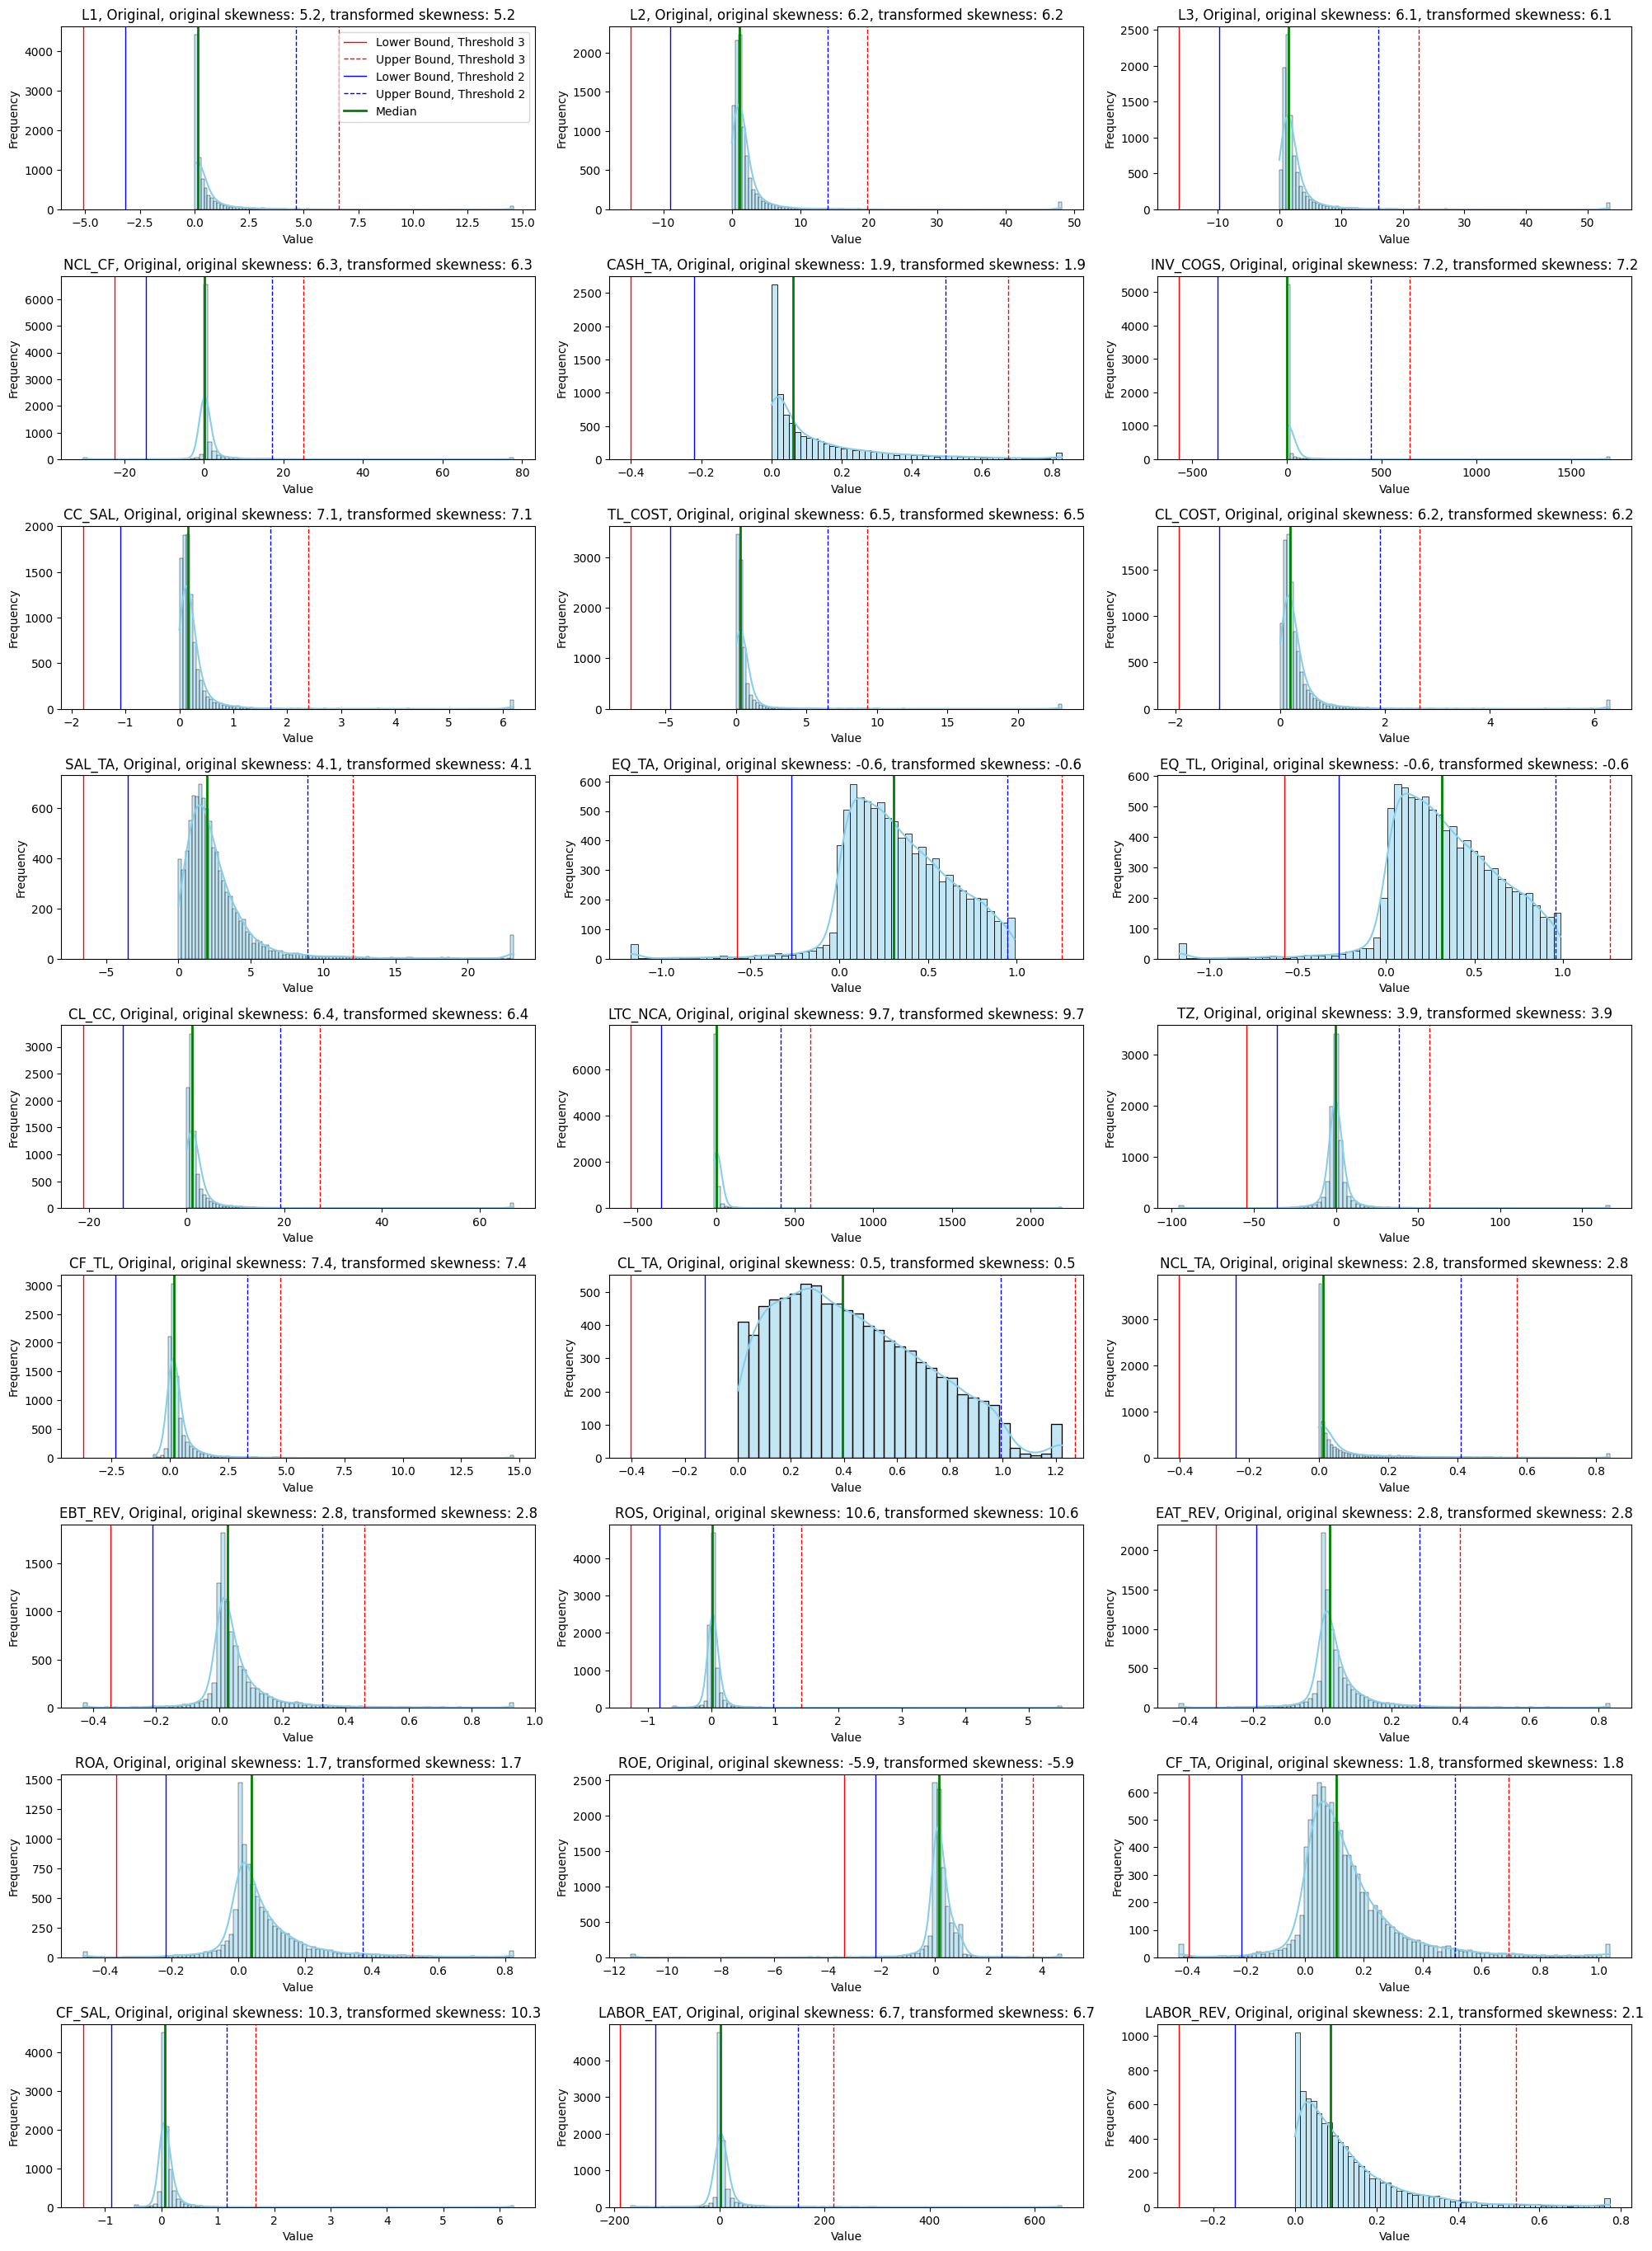

In [71]:
plot_histograms(data_capped, RATIOS, False)

## 2. Analýza multikolinearity

In [19]:
Q = data.query('combined_issue_criteria_3y_off == 1').shape[0]
subset = pd.concat(
    [
        data.query('combined_issue_criteria_3y_off == 1').sample(Q),
        data.query('combined_issue_criteria_3y_off == 0').sample(Q)
    ], axis = 0
)

In [20]:
for col in RATIOS:
    mean_value = subset[col].mean()
    subset[col] = subset[col].fillna(mean_value)

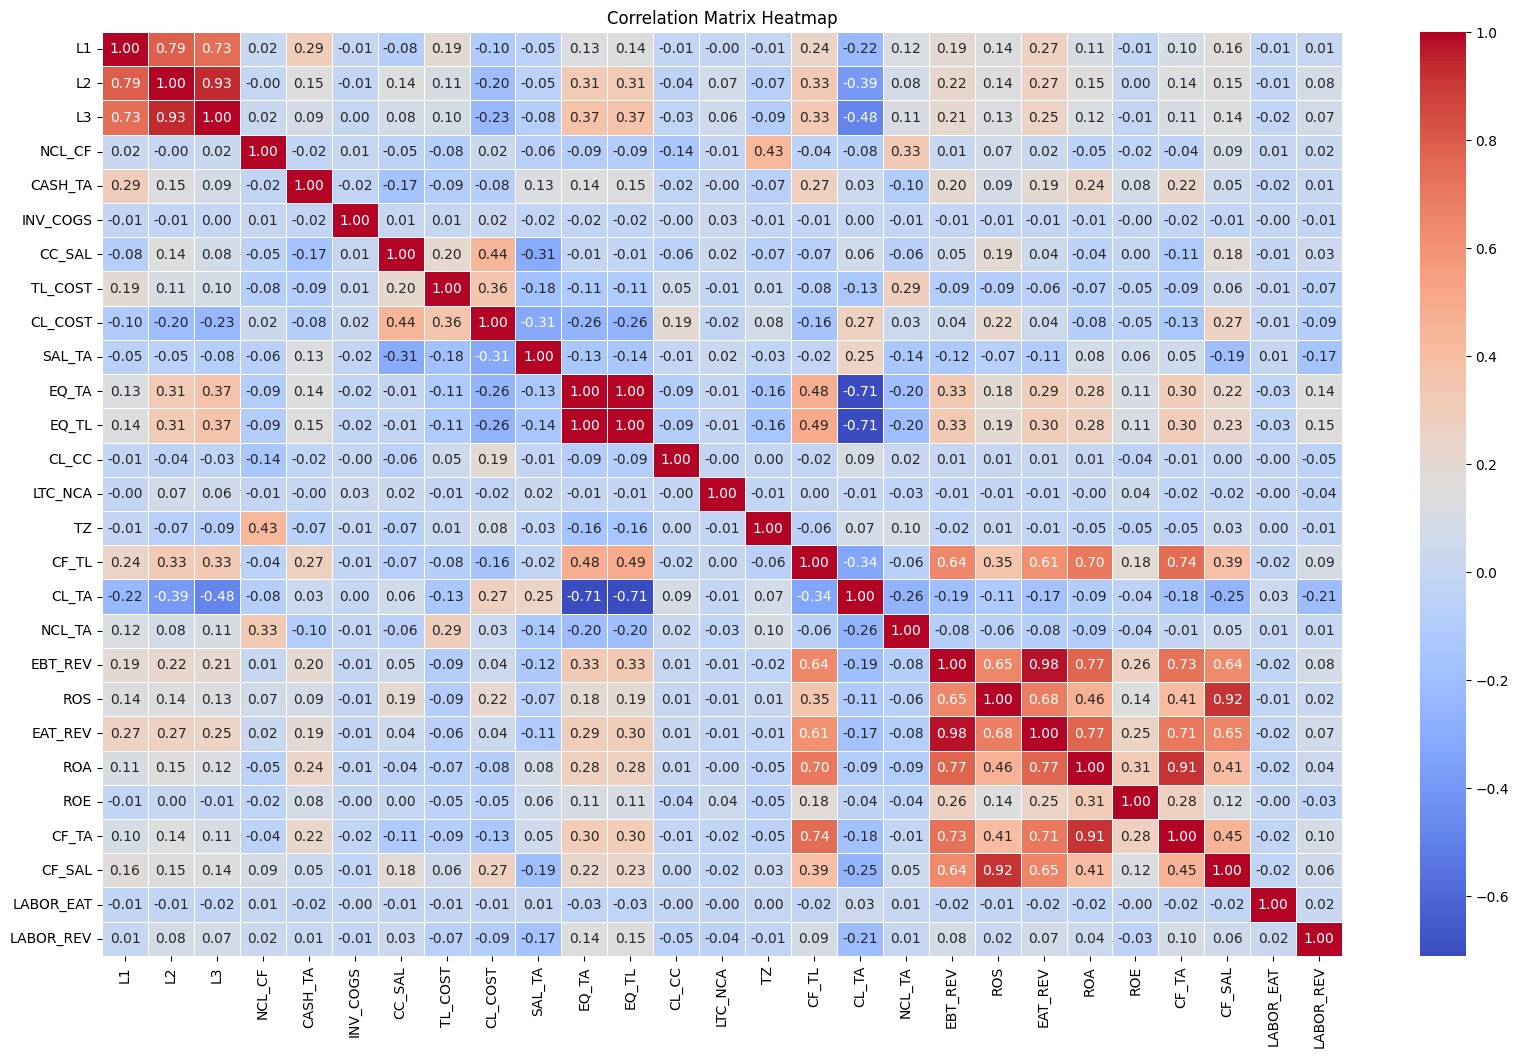

In [21]:
# Calculate the correlation matrix
correlation_matrix = subset[RATIOS].corr()

# Create a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:
len(RATIOS)

27

In [37]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = subset[RATIOS].drop(columns = ['L2', 'EQ_TL', 'EAT_REV', 'CF_SAL', 'CF_TA']).copy()

# Adding a constant for the intercept
df_const = add_constant(df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = df_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

display(vif_data)

,feature,VIF
0,const,35.225465
1,L1,3.131823
2,L3,3.569007
3,NCL_CF,1.498890
4,CASH_TA,1.348719
5,INV_COGS,1.004337
6,CC_SAL,1.635119
7,TL_COST,1.652407
8,CL_COST,2.120572
9,SAL_TA,1.473230


In [39]:
RATIOS_SUBSET = subset[RATIOS].drop(columns = ['L2', 'EQ_TL', 'EAT_REV', 'CF_SAL', 'CF_TA']).columns

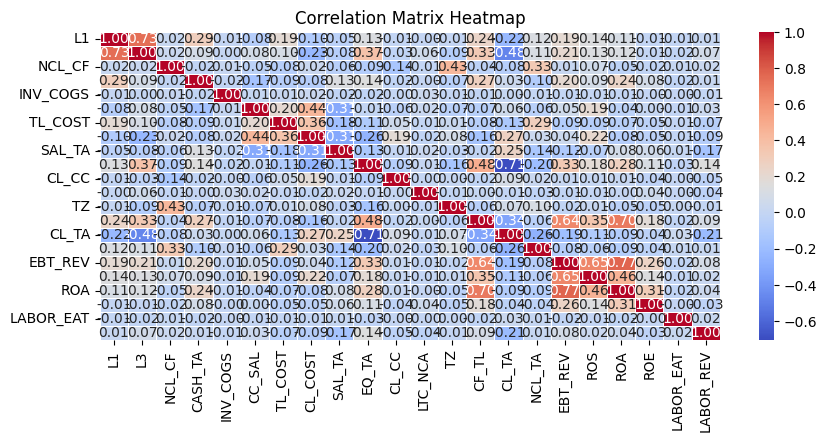

In [40]:
# Calculate the correlation matrix
correlation_matrix = subset[RATIOS_SUBSET].corr()

# Create a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [41]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = subset[RATIOS_SUBSET].copy()

# Adding a constant for the intercept
df_const = add_constant(df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = df_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

display(vif_data)

,feature,VIF
0,const,35.225465
1,L1,3.131823
2,L3,3.569007
3,NCL_CF,1.498890
4,CASH_TA,1.348719
5,INV_COGS,1.004337
6,CC_SAL,1.635119
7,TL_COST,1.652407
8,CL_COST,2.120572
9,SAL_TA,1.473230


In [42]:
from scipy.stats import shapiro

def check_normality(dataframe):
    # Dictionary to store the results
    results = {}

    # Loop through each column in the DataFrame
    for column in dataframe.columns:
        # Skip columns with non-numeric data
        if dataframe[column].dtype.kind not in 'biufc':
            continue
        
        # Perform Shapiro-Wilk test on the column
        stat, p_value = shapiro(dataframe[column].dropna())  # Drop NA values for the test
        
        # Store the result in the dictionary
        results[column] = {'Statistic': stat, 'P-value': p_value}

    return results


pd.DataFrame(check_normality(data[RATIOS])).T

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Statistic,P-value
L1,0.285679,0.000000e+00
L2,0.327919,0.000000e+00
L3,0.374178,0.000000e+00
NCL_CF,0.140013,0.000000e+00
CASH_TA,0.764310,0.000000e+00
INV_COGS,0.004701,0.000000e+00
CC_SAL,0.265190,0.000000e+00
TL_COST,0.064082,0.000000e+00
CL_COST,0.355125,0.000000e+00
SAL_TA,0.626671,0.000000e+00


# 3. Overenie diskriminacnej schopnosti

In [53]:
import pandas as pd
from scipy.stats import ttest_ind, levene

# Load your dataset
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and modify this line to load your dataset

# Sample data and class division for demonstration
df = pd.DataFrame(subset[RATIOS + ['combined_issue_criteria_3y_off']])

# Separate the dataset into two classes
class0 = df[df['combined_issue_criteria_3y_off'] == 0]
class1 = df[df['combined_issue_criteria_3y_off'] == 1]

# Perform a t-test and Levene's test for each feature
results = []
for feature in df.columns[:-1]:  # Exclude the class label column
    # Levene's test for equality of variances
    stat, p_val_levene = levene(class0[feature], class1[feature])
    
    # Decide which t-test to use based on Levene's test result
    equal_var = p_val_levene > 0.05  # Assume equal variances if Levene's test is not significant
    t_stat, p_val_ttest = ttest_ind(class0[feature], class1[feature], equal_var=equal_var)

    equal_mean = p_val_ttest > 0.05
    
    results.append({
        'Feature': feature,
        'Mean 1': class0[feature].mean(),
        'Mean 2': class1[feature].mean(),
        'Levene Statistic': stat,
        'Levene P-value': p_val_levene,
        'T-statistic': t_stat,
        'T-test P-value': p_val_ttest,
        'Equal Variances Assumed': equal_var,
        'Equal Mean': equal_mean
    })

results_df = pd.DataFrame(results).sort_values('T-test P-value')
display(results_df)


,Feature,Mean 1,Mean 2,Levene Statistic,Levene P-value,T-statistic,T-test P-value,Equal Variances Assumed,Equal Mean
10,EQ_TA,0.375034,0.151604,0.873149,3.502474e-01,16.150537,6.696591e-54,True,False
11,EQ_TL,0.380653,0.154485,0.916228,3.386340e-01,16.103114,1.278334e-53,True,False
16,CL_TA,0.430650,0.636919,29.053958,8.261758e-08,-13.809062,1.224574e-40,False,False
18,EBT_REV,0.050160,0.017502,12.377665,4.485231e-04,9.265773,7.327969e-20,False,False
20,EAT_REV,0.039147,0.012326,7.630788,5.813732e-03,8.772051,5.081660e-18,False,False
23,CF_TA,0.148370,0.090333,0.177570,6.735356e-01,8.048266,1.787814e-15,True,False
15,CF_TL,0.348936,0.161498,22.623732,2.175733e-06,7.670499,3.281252e-14,False,False
21,ROA,0.078794,0.035813,0.070280,7.909688e-01,7.274685,5.785411e-13,True,False
24,CF_SAL,0.088880,0.041347,8.551117,3.509142e-03,6.937968,6.798567e-12,False,False
2,L3,2.230738,1.547709,18.772026,1.579138e-05,5.919478,4.301862e-09,False,False


## 4. Zakladne popisne statistiky

In [ ]:
subset.query('combined_issue_criteria_3y_off == 1')[RATIOS_SUBSET].describe().T

,count,mean,std,min,25%,50%,75%,max
SAL_TA,1011.0,3.837639,8.093894,0.075003,1.378678,2.229987,3.904755,146.299417
L3,1011.0,1.703794,2.391919,0.015903,0.935375,1.092780,1.612867,34.494401
ROE,1011.0,-0.514246,9.684605,-276.756757,-0.133416,0.070328,0.388657,80.193576
EAT_TA,1011.0,0.021981,0.120828,-0.755073,-0.006559,0.010963,0.053732,0.652771
TL_TA,1011.0,0.860742,0.309952,0.026637,0.703604,0.896116,0.988172,3.236349
CASH_TA,1011.0,0.109238,0.162828,0.000000,0.008850,0.039847,0.136729,1.097055
ROS,1011.0,0.005783,0.060549,-0.284867,-0.003254,0.004199,0.021108,0.301528
NCL_TA,1011.0,0.077847,0.182526,0.000000,0.000345,0.006975,0.054937,1.656374
TL_SAL,1011.0,0.580263,0.849412,0.001863,0.196682,0.368817,0.637535,10.831183
